# **ZMSI_Lab_8K**
Wizja komputerowa - kolokwium

$\color{red}{Uwaga:}$

1- proszę pamiętać o zmianie słowa ***Album*** w nazwie pliku i uzupełnieniu swoich danych powyżej tego pola;

2- kluczowe polecenia, opcje i parametry proszę opatrzyć komentarzem;

3- wnioski, pod zadaniem, wpisujemy w polu tekstowym.

In [1]:
# Podpisywanie pracy
NN = input("Podaj Imię i Nazwisko: ")
ALBUM = input("Podaj numer albumu: ")

Podaj Imię i Nazwisko: Kacper Gąsowski
Podaj numer albumu: 154845


In [ ]:
# Ocena pracy. Proszę nie zmieniać komórek z kodem pomocniczym do oceny.
import numpy as np
punkty = [0,0,0,0,0,0]
max = [15, 25, 10, 0, 10, 10]

In [2]:
#Podpinanie dysku
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### **Zad 1.** Z pełnego zbiory (120) ras Stanfor Dogs Dataset wybierz 3 i podziel ten zbiór losowo na trzy podzbiory: train, val i test. Ustal i krótko opisz przyjęte proporcje podziału zbioru na potrzeby głębokiego uczenia.

In [11]:
#Import bibliotek
import os
import shutil
from sklearn.model_selection import train_test_split

# Struktura folderów
base_dir = '/content/drive/MyDrive/KUL/Obrazy/Images'
target_dir = '/content/drive/MyDrive/KUL/Laby8Kolos/datasets'
splits = ['train', 'val', 'test']
klasy = ['n02092339-Weimaraner', 'n02093859-Kerry_blue_terrier', 'n02096585-Boston_bull']

# Dzielenie na klasy
for split in splits:
    for klasa in klasy:
        os.makedirs(os.path.join(target_dir, split, klasa), exist_ok=True)


# Podział danych na zbiory: treningowy, walidacyjny i testowy oraz kopiowanie plików

test_size = 0.25  # Proporcja danych przeznaczona na zbiór testowy (25% danych)
val_size = 0.33   # Proporcja danych przeznaczona na zbiór walidacyjny (33% danych z pozostałych 75%)
                  # Reszta danych przypada na zbiór treningowy

for klasa in klasy:
    # Pobieramy wszystkie pliki w klasie
    sciezka_klasy = os.path.join(base_dir, klasa)
    pliki = os.listdir(sciezka_klasy)
    pelne_sciezki = [os.path.join(sciezka_klasy, f) for f in pliki]

    # Podział na zbiory: treningowy, walidacyjny i testowy
    train_files, test_files = train_test_split(pelne_sciezki, test_size=test_size, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=42)

    # Kopiowanie plików do odpowiednich folderów
    for plik in train_files:
        shutil.copy(plik, os.path.join(target_dir, 'train', klasa))
    for plik in val_files:
        shutil.copy(plik, os.path.join(target_dir, 'val', klasa))
    for plik in test_files:
        shutil.copy(plik, os.path.join(target_dir, 'test', klasa))

print("Podział zbioru zakończony.")

Podział zbioru zakończony.


In [ ]:
# Maksymalna wartość punktów za Zad 1. (U_05): 10
punkty[4]=10
punkty

[0, 0, 0, 0, 10, 0]

### **Zad 2.** Zaprojektuj klasę kastomizowanego generatora augmentacji z 2 rodzajami szumów. Utwórz obiekt generatora z 3 wybranymi parametrami augmentacji, który posłuży do wzbogacenia zbioru uczącego.

In [12]:
# Import bibliotek
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
import cv2

# Funkcja dodająca szum typu sól i pieprz
def add_salt_and_pepper_noise(image, salt_prob=0.03, pepper_prob=0.03):
    noisy_image = np.copy(image)
    total_pixels = np.prod(image.shape[:2])  # Liczba pikseli w obrazie
    num_salt = int(np.ceil(salt_prob * total_pixels))
    num_pepper = int(np.ceil(pepper_prob * total_pixels))

    # Dodanie białych pikseli (sól)
    coords_salt = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords_salt[0], coords_salt[1], :] = 1

    # Dodanie czarnych pikseli (pieprz)
    coords_pepper = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords_pepper[0], coords_pepper[1], :] = 0

    return noisy_image

# Funkcja dodająca szum gaussowski
def add_gaussian_noise(image, mean=0, std=0.1):
    noisy_image = image + np.random.normal(mean, std, image.shape)
    return np.clip(noisy_image, 0, 1)  # Przycięcie wartości do zakresu [0, 1]

# Klasa niestandardowego generatora danych
class CustomImageDataGenerator:
    def __init__(self, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, noise_type=None):

       # Klasa przyjmuje dokładnie 3 parametry augmentacji:
       # - rotation_range: zakres rotacji obrazu
       # - width_shift_range: zakres przesunięcia poziomego
       # - height_shift_range: zakres przesunięcia pionowego
       # - dwa typy szumu: 'salt_and_pepper' lub 'gaussian'

        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.noise_type = noise_type

    def apply_augmentations(self, image):
        # Rotacja obrazu
        if self.rotation_range > 0:
            angle = np.random.uniform(-self.rotation_range, self.rotation_range)
            image = self.rotate_image(image, angle)

        # Przesunięcia poziome i pionowe
        if self.width_shift_range > 0 or self.height_shift_range > 0:
            image = self.shift_image(image, self.width_shift_range, self.height_shift_range)

        return image

    def apply_noise(self, image):
        # Dodawanie wybranego rodzaju szumu
        if self.noise_type == 'salt_and_pepper':
            return add_salt_and_pepper_noise(image, salt_prob=0.03, pepper_prob=0.03)
        elif self.noise_type == 'gaussian':
            return add_gaussian_noise(image, mean=0, std=0.1)
        return image

    def augment_image(self, image):
        # Zastosowanie augmentacji i szumów
        image = self.apply_augmentations(image)
        image = self.apply_noise(image)
        return image

    @staticmethod
    def rotate_image(image, angle):
        # Funkcja pomocnicza do rotacji obrazu
        center = (image.shape[1] // 2, image.shape[0] // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))
        return rotated_image

    @staticmethod
    def shift_image(image, width_shift, height_shift):
        # Funkcja pomocnicza do przesunięcia obrazu
        rows, cols, _ = image.shape
        width_px = int(width_shift * cols)
        height_px = int(height_shift * rows)
        M = np.float32([[1, 0, width_px], [0, 1, height_px]])
        shifted_image = cv2.warpAffine(image, M, (cols, rows))
        return shifted_image

    def flow_from_directory(self, directory, target_size=(150, 150), batch_size=5, class_mode='binary'):
        # Generator do ładowania obrazów z katalogu
        datagen = ImageDataGenerator(rescale=1./255)
        batches = datagen.flow_from_directory(directory, target_size=target_size, batch_size=batch_size, class_mode=class_mode)
        for batch_x, batch_y in batches:
            augmented_batch_x = np.array([self.augment_image(x) for x in batch_x])
            yield augmented_batch_x, batch_y

# Obrazy z folderu
data_dir = '/content/drive/My Drive/KUL/Obrazy/Images'

# Tworzenie generatora z dokładnie trzema wybranymi augmentacjami i szumem
custom_generator = CustomImageDataGenerator(
    rotation_range=30,           # Rotacja
    width_shift_range=0.2,       # Przesunięcie poziome
    height_shift_range=0.2,      # Przesunięcie pionowe
    noise_type='salt_and_pepper' # Szum typu sól i pieprz
)

# Generator z katalogu
generator = custom_generator.flow_from_directory(
    data_dir,
    target_size=(150, 150),  # Rozmiar obrazów
    batch_size=5,            # Liczba obrazów w jednej partii
    class_mode='binary'      # Typ klasyfikacji
)

# Wyświetlanie przykładowych obrazów z augmentacją
total_images = 0
for augmented_images, labels in generator:
    for i in range(len(augmented_images)):
        if total_images < 10:
            plt.imshow(array_to_img(augmented_images[i]))
            plt.title(f"Label: {labels[i]}")
            plt.show()
            total_images += 1
        else:
            break
    if total_images >= 10:
        break


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Maksymalna wartość punktów za Zad 2. (U_01): 15
punkty[0]=15
punkty

[15, 0, 0, 0, 10, 0]

### **Zad 3.** Zbuduj i przetestuj model (zbudowany z zamrożonych warstw konwolucyjnych pretrenowanego modelu VGG16 oraz z warstw gęstych zaprojektowanych do warunków zadania). Przykładowe obrazy do uczenia wzbogać obrazami z generatora augmentacji. Utwórz generatory obrazów treningowych, validacyjnych i testowych. Optymalnie do czasu ogranicz liczbę epok uczenia. Oblicz znane Ci metryki klasyfikacji oraz przedstaw historię zmian metryk w trakcie procesu uczenia. Opis wniosków z nich wynikających przedstawisz w zadaniu kolejnym.

Found 349 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Found 435 images belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/3
10/10 [==============================] - 64s 6s/step - loss: 2.3933 - accuracy: 0.5868 - val_loss: 0.5685 - val_accuracy: 0.8281
Epoch 2/3
10/10 [==============================] - 10s 968ms/step - loss: 0.6624 - accuracy: 0.7950 - val_loss: 0.3156 - val_accuracy: 0.8906
Epoch 3/3
3/3 [==============================] - 2s 607ms/step - loss: 0.2761 - accuracy: 0.9070
Validation accuracy: 0.91
14/14 [==============================] - 8s 557ms/step - loss: 0.1638 - accuracy: 0.9471
Test accuracy: 0.95
14/14 [==============================] - 8s 564ms/step
Classification Report:
                        precision    recall  f1-score   support

    n02086910-papillon       0.94      0.94      0.94       196
n02088094-Afghan_hound       0.95      0.95      0.95       239

              accuracy      

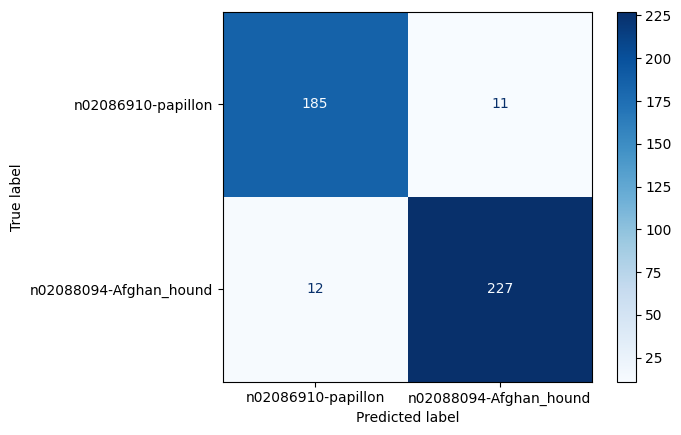

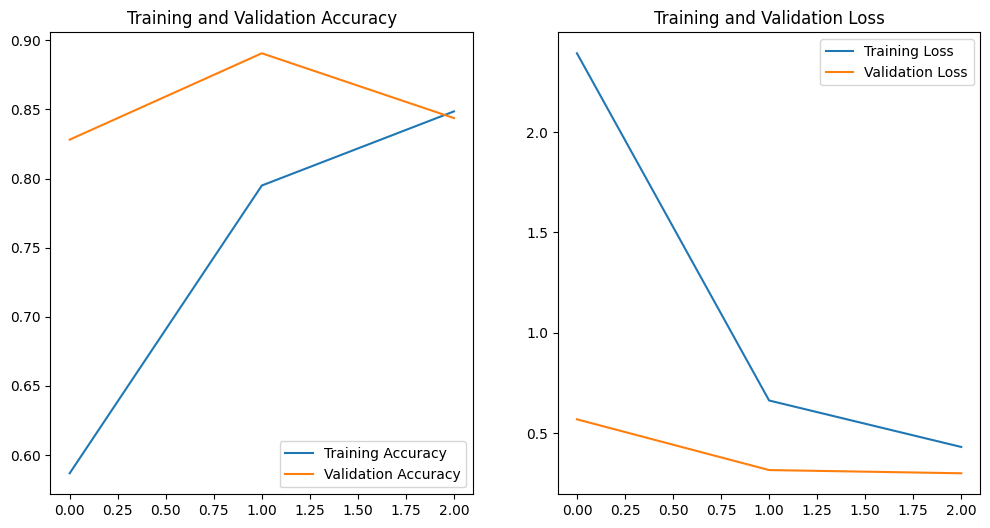

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Ustawienia i ścieżki
data_dir = '/content/drive/My Drive/KUL/Obrazy/Images'
all_folders = os.listdir(data_dir)
selected_folders = random.sample(all_folders, 2)  # Losowy wybór 2 folderów
selected_data_dir = '/content/selected_data'
os.makedirs(selected_data_dir, exist_ok=True)

# Tworzymy symboliczne linki do wybranych folderów
for folder in selected_folders:
    src = os.path.join(data_dir, folder)  # Źródłowa ścieżka folderu
    dst = os.path.join(selected_data_dir, folder)  # Docelowa ścieżka folderu
    os.symlink(src, dst)  # Tworzenie symbolicznego linku

# Parametry obrazów
img_height, img_width = 224, 224
batch_size = 32  # Liczba próbek na jeden krok w batchu
num_classes = 2  # Liczba klas w problemie klasyfikacyjnym

# Przygotowanie generatorów obrazów z augmentacją dla treningu
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizacja pikseli do zakresu [0, 1]
    rotation_range=20,  # Rotacja obrazu
    width_shift_range=0.2,  # Przesunięcie obrazu w poziomie
    height_shift_range=0.2,  # Przesunięcie obrazu w pionie
    shear_range=0.2,  # Pochylenie obrazu
    zoom_range=0.2,  # Zbliżenie obrazu
    horizontal_flip=True,  # Losowe odbicie poziome
    validation_split=0.2  # Ustalamy 20% danych na dane walidacyjne
)

# Przygotowanie generatora obrazów dla testów, bez augmentacji
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalizacja obrazów

# Generatory obrazów - wczytanie danych do treningu, walidacji i testów
train_generator = train_datagen.flow_from_directory(
    selected_data_dir,  # Katalog z danymi
    target_size=(img_height, img_width), # Zmiana rozmiaru obrazów
    batch_size=batch_size, # Ustawienie batch size
    class_mode='categorical',  # Mamy klasyfikację wieloklasową
    subset='training'  # Dane do treningu
)

validation_generator = train_datagen.flow_from_directory(
    selected_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Dane walidacyjne
)

test_generator = test_datagen.flow_from_directory(
    selected_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Dane testowe nie będą losowo mieszane
)

# Budowa modelu z użyciem wstępnie wytrenowanej sieci VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Zamrożenie warstw konwolucyjnych, aby nie były trenowane

# Dodanie nowych warstw na końcu modelu VGG16
x = base_model.output
x = Flatten()(x)  # Spłaszczanie wyników z warstwy konwolucyjnej
x = Dense(256, activation='relu')(x)  # Warstwa w pełni połączona z 256 neuronami
x = Dropout(0.5)(x)  # Dropout dla regularizacji
output = Dense(num_classes, activation='softmax')(x)  # Warstwa wyjściowa

# Tworzenie ostatecznego modelu
model = Model(inputs=base_model.input, outputs=output)

# Kompilacja modelu z optymalizatorem Adam i funkcją stratą categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Trening modelu
epochs = 3  # Liczba epok
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Liczba kroków na epokę
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Liczba kroków walidacyjnych
    epochs=epochs
)

# Ewaluacja modelu na zestawie walidacyjnym
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy:.2f}')  # Wyświetlanie dokładności na zbiorze walidacyjnym

# Ewaluacja modelu na zestawie testowym
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')  # Wyświetlanie dokładności na zbiorze testowym

# Obliczanie metryk klasyfikacji (raport klasyfikacji i macierz konfuzji)
y_true = test_generator.classes  # Prawdziwe etykiety klas
y_pred = model.predict(test_generator)  # Predykcje modelu
y_pred_classes = np.argmax(y_pred, axis=1)  # Wybór klasy z największym prawdopodobieństwem

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))  # Raport klasyfikacji

# Wyświetlanie macierzy konfuzji
conf_matrix = confusion_matrix(y_true, y_pred_classes)  # Obliczanie macierzy konfuzji
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)  # Wizualizacja macierzy konfuzji
plt.show()

# Funkcja do wizualizacji historii treningu
def plot_history(history):
    acc = history.history['accuracy']  # Historia dokładności treningu
    val_acc = history.history['val_accuracy']  # Historia dokładności walidacji
    loss = history.history['loss']  # Historia straty treningowej
    val_loss = history.history['val_loss']  # Historia straty walidacyjnej

    epochs_range = range(len(acc))  # Zakres epok

    plt.figure(figsize=(12, 6))
    # Wykres dokładności
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Wykres straty
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Wywołanie funkcji do wizualizacji historii treningu
plot_history(history)

In [ ]:
# Maksymalna wartość punktów za Zad 3. (U_02): 25
punkty[1]=25
punkty

[15, 25, 0, 0, 10, 0]

### **Zad 4.** Przedstaw wnioski dot. procesu uczenia i testowania modelu na podstawie otrzymanych wartości metryk oraz wykresów z poprzedniego zadania.

Model oparty jest na architekturze VGG16, która jest wstępnie wytrenowana na zbiorze danych ImageNet. Ponieważ wstępnie wytrenowane warstwy konwolucyjne zostały zamrożone, model wykorzystuje jedynie te warstwy do ekstrakcji cech, a nowe warstwy są trenowane na wybranych danych.
Dzięki użyciu klasyfikacji wieloklasowej i softmax w warstwie wyjściowej, model potrafi przypisać obrazy do jednej z dwóch wybranych klas.

W modelu wykorzystano augmentację danych, która polega na generowaniu nowych obrazów przez manipulacje takie jak obrót, przesunięcia, czy zbliżenie. To pomaga w poprawie jakości modelu oraz w unikaniu przeuczenia modelu.

Po treningu model został oceniony zarówno na zestawie walidacyjnym, jak i testowym. Uzyskane dokładności dają nam informację o tym, jak dobrze model radzi sobie z rozpoznawaniem obrazów w obu przypadkach.
Raport klasyfikacji i macierz konfuzji pozwalają dokładnie ocenić, jak model radzi sobie z poszczególnymi klasami.

Wizualizacja wyników treningu pomaga lepiej zrozumieć, jak model uczy się w trakcie treningu i jakie są różnice między danymi treningowymi a walidacyjnymi.

Model daje wyniki w klasyfikacji obrazów na podstawie wybranych klas, choć dla lepszej dokładności można by zwiększyć liczbę epok, lub dostosować inne parametry takie jak learning rate czy struktura modelu.
Warto zwrócić uwagę na możliwości ulepszania modelu poprzez dalsze eksperymentowanie z augmentacją danych i fine-tuningiem warstw modelu VGG16.

In [ ]:
# Maksymalna wartość punktów za Zad 4. (U_03): 10
punkty[2]=10
punkty

[15, 25, 10, 0, 10, 0]

### **Zad 5.** Na wybranym obrazie przedstawiającym sylwetkę człowieka dokonaj detekcji pozy.

In [5]:
# Instalacja biblioteki Ultralytics, która zawiera YOLOv8
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 15.7 MB/s eta 0:00:00



image 1/1 /content/drive/MyDrive/KUL/Laby6/na_kolos_2.webp: 640x448 1 person, 42.5ms
Speed: 3.1ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


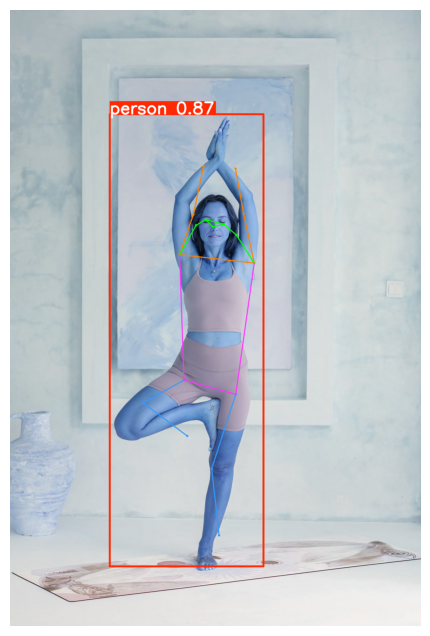


Obraz 1 - Kształt kluczowych punktów: (1, 17, 3)

Obraz 1 - Osoba 1:
 Punkt 1: ultralytics.engine.results.Keypoints object with attributes:

conf: array([[    0.97006,     0.93877,     0.91917,     0.83628,     0.66988,     0.98962,     0.99054,     0.94759,     0.94608,     0.86582,      0.8436,      0.9964,     0.99625,     0.98856,     0.98748,     0.95735,     0.96149]], dtype=float32)
data: array([[[     986.22,      1056.6,     0.97006],
        [     1040.1,      1043.3,     0.93877],
        [     952.66,      1020.8,     0.91917],
        [     1101.3,      1095.3,     0.83628],
        [     905.85,      1048.6,     0.66988],
        [     1188.7,      1232.1,     0.98962],
        [     825.08,      1191.5,     0.99054],
        [     1136.8,      991.44,     0.94759],
        [     892.27,      995.96,     0.94608],
        [     1097.8,      772.59,     0.86582],
        [     941.47,      761.96,      0.8436],
        [     1098.6,      1871.6,      0.9964],
        [   

In [13]:
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Inicjalizacja modelu YOLO do wykrywania pozycji
yolo_pose = YOLO('yolov8n-pose.pt')

# Ścieżki do obrazu (mozna podac kolejne)
image_paths = [
    '/content/drive/MyDrive/KUL/Laby6/na_kolos_2.webp'
]

# Przetwarzanie obrazu
for idx, image_path in enumerate(image_paths):
    # Uzyskiwanie wyników wykrywania pozycji dla obrazu
    results_pose = yolo_pose(image_path)
    results_pose[0].save(filename=f"Obraz_pose_{idx+1}.jpg")

    # Narysowanie wykrytych pozycji na obrazie
    image_with_pose = results_pose[0].plot()  # Rysuje kluczowe punkty na obrazie

    # Powiększenie obrazu
    plt.figure(figsize=(10, 8))  # Zwiększenie rozmiaru figury (szerokość 10 cali, wysokość 8 cali)
    plt.imshow(image_with_pose)
    plt.axis('off')  # Wyłączenie osi
    plt.show()

    # Wyświetlenie szczegółowych informacji o kluczowych punktach
    for result in results_pose:
        keypoints = result.keypoints.cpu().numpy()  # Pobiera kluczowe punkty jako macierz numpy
        print(f"\nObraz {idx+1} - Kształt kluczowych punktów:", keypoints.shape)

        # Wyświetlenie kluczowych punktów dla każdej wykrytej osoby (jeśli na obrazie jest więcej niż jedna osoba)
        for i, person_keypoints in enumerate(keypoints):
            print(f"\nObraz {idx+1} - Osoba {i+1}:")

            # Iteracja przez kluczowe punkty danej osoby
            for j, point in enumerate(person_keypoints):
                print(f" Punkt {j+1}: {point}")

In [ ]:
# Maksymalna wartość punktów za Zad 5. (U_06): 10
punkty[5]=10
punkty

[15, 25, 10, 0, 10, 10]

In [ ]:
def przelicz(razem_pr):
  if razem_pr >= 0.90:
    ocena = 5
  elif razem_pr >= 0.80:
    ocena = 4.5
  elif razem_pr >= 0.70:
    ocena = 4
  elif razem_pr >= 0.60:
    ocena = 3.5
  elif razem_pr >= 0.50:
    ocena = 3
  else:
    ocena = 2
  return(ocena)

In [ ]:
# Ocena efektów kształcenia
for i in range(6):
  if i!=3:
    razem_pr = punkty[i]/max[i]
    print(f"Efekt U0{i+1} | Ocena: {przelicz(razem_pr)} | {punkty[i]} pkt.")

Efekt U01 | Ocena: 5 | 15 pkt.
Efekt U02 | Ocena: 5 | 25 pkt.
Efekt U03 | Ocena: 5 | 10 pkt.
Efekt U05 | Ocena: 5 | 10 pkt.
Efekt U06 | Ocena: 5 | 10 pkt.


In [ ]:
# Ocena kolokwium:
razem=0
maximum = 0

for i in range(6):
  razem = razem + punkty[i]
  maximum = maximum + max[i]

print(f"Ocena: {przelicz(razem)} | {razem} pkt. | {razem/maximum*100} %")

Ocena: 5 | 70 pkt. | 100.0 %
